<img src="https://github.com/strath-sdr/RFSoC-Book/blob/main/rfsoc_book/notebooks/common/rfsoc_book_banner.jpg?raw=1" alt="University of Strathclyde" align="left">

# Notebook Set D

---

## 02 - EVM and BER
In this notebook we will explore Additive White Gaussian Noise (AWGN) and investigate common evaluation metrics to assess link quality including the Error Vector Magnitude (EVM) and Bit Error Rate (BER).

## Table of Contents
* [1. Introduction](#introduction)
* [2. Signal to Noise Ratio](#snr)
* [3. Error Vector Magnitude](#evm)
* [4. Bit Error Rate](#ber)
* [5. Conclusion](#conclusion)

## References
[1] - B. Sklar, Digital Communications: Fundamentals and Applications, 2nd Ed. Prentice Hall, 2001.

## Revision
* **v1.0** | 20/01/23 | *First Revision*

---


## 1. Introduction

A signal acquired by a receiver is unlikely to be perfect such as those given in the constellation graphs of the [previous notebook](01_baseband_modulation.ipynb). In a practical scenario, the received signal will be imperfect due to noise from the environment, which includes thermal noise arising from the analog receiver components. It is conventional to model the combined noise arising from all of these sources as Additive White Gaussian Noise (AWGN). Therefore, AWGN is added to the received signal. AWGN follows a gaussian distribution with mean $\mu = 0$, and the variance $\sigma^{2}$ that describes the spread of noise amplitudes.

In Python we can use the *random* module and draw from a gaussian distribution for noise to add to symbols with $\mu = 0$ and $\sigma^{2} = 1$.

In [1]:
import numpy as np

noise = np.random.randn(50000,1)
print("Mean of my signal: {}".format(np.mean(noise)))
print("Variance of my signal: {}".format(np.var(noise)))

Mean of my signal: -0.000625795355450768
Variance of my signal: 1.0071365694016956


While the mean is not exactly 0 and variance is not exactly 1, the values are pretty close. The more samples we compute the main and variance across, the closer we would get to the ideal statistical values.

Plotting the samples as a histogram is a great sanity check to confirm that we have a normal distribution. We should see something resembling the characteristic bell curve that we are all too familiar with!

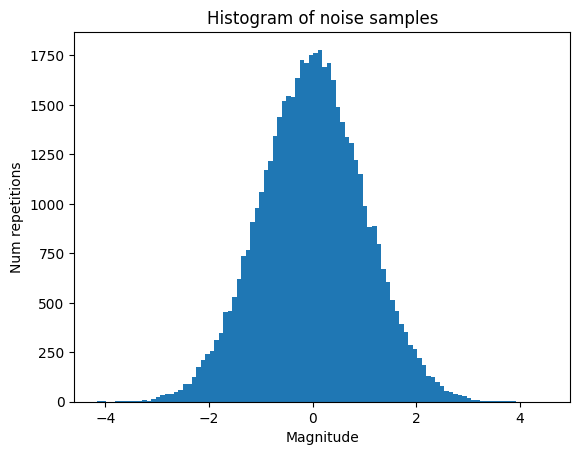

In [2]:
import matplotlib.pyplot as plt

plt.hist(noise, bins=100)
plt.title('Histogram of noise samples')
plt.xlabel('Magnitude')
plt.ylabel('Num repetitions')
plt.show()

The variance of the distribution can be manipulated by multiplying the standard distribution with the square root of the variance. E.g. multiplying our noise vector by 2, gives us the variance of 4.

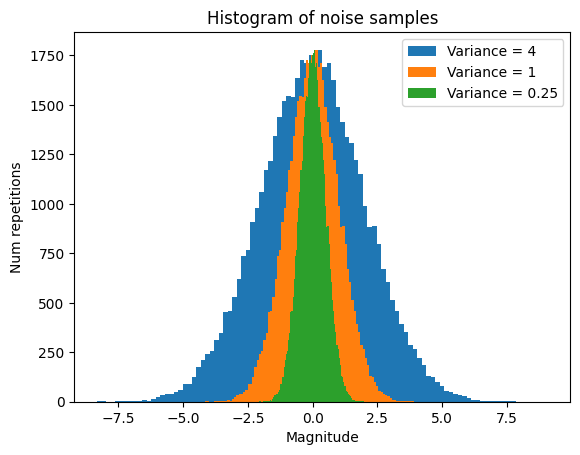

In [3]:
plt.hist(noise*2, bins=100)
plt.hist(noise, bins=100)
plt.hist(noise*0.5, bins=100)
plt.title('Histogram of noise samples')
plt.xlabel('Magnitude')
plt.ylabel('Num repetitions')
plt.legend(('Variance = 4', 'Variance = 1', 'Variance = 0.25'))
plt.show()

## 2. Signal to Noise Ratio <a class="anchor" id="snr"></a>

When exploring the topic of noise, we should also discuss a measurement named the Signal to Noise Ratio (SNR). The SNR is simply the ratio of the power of the signal of interest and the power of the noise.

$$
\text{SNR} = P_{s}/P_{n}
$$

SNR is most often talked about in terms of decibels (dB). Rather than use division to compute the SNR, we can instead use subtraction as below.

$$
\text{SNR(dB)} = P_{s}(\text{dB}) - P_{n}(\text{dB})
$$

Let's say we want to add noise to our QPSK signal so that the SNR is 20dB. First we need to measure the power of our signal.

In [4]:
snr = 10 # specify SNR in dB
qpsk_scheme = [1+1j, 1-1j, -1+1j, -1-1j]
ints = np.random.randint(0,4,1024)
qpsk_symbols = [qpsk_scheme[i] for i in ints]
sig_power = np.mean(np.abs(qpsk_symbols)**2) # calculate signal power
sig_power_db = 10* np.log10(sig_power) # convert to dB

Recall that $\text{SNR} = P_{s}/P_{n}$, which is equivalent to $\text{SNR(dB)} = P_{s}(\text{dB}) - P_{n}(\text{dB})$. Now that we have our signal power and desired SNR, we can easily calculate the power of our desired noise signal.

In [5]:
noise_power_db = sig_power_db - snr
noise_power = 10**(noise_power_db / 10)

Now generate a noise signal with the desired noise power. Note that we have a division by 2 in the code, which is added because we are dealing with complex signals - if we were dealing with a single channel real signal we would simply multiply our random noise samples by the square root of the desired noise power.

In [6]:
complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(qpsk_symbols)) + \
                                        np.random.randn(len(qpsk_symbols))*1j)

Add noise to the QPSK symbols by adding the complex noise samples to the symbols.

In [7]:
qpsk_symbols_noisy = qpsk_symbols + complex_noise

Plot the noisy QPSK constellation. The red markers showing the ideal constellation points for the QPSK modulation scheme help to demonstrate the amount of error in the received signal samples. We can still see 4 distinct clusters and could receive our data relatively error-free.

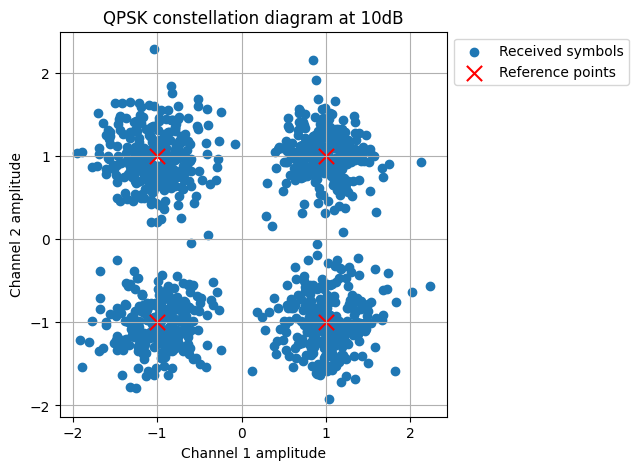

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(qpsk_symbols_noisy.real, qpsk_symbols_noisy.imag)
plt.scatter(np.real(qpsk_scheme), np.imag(qpsk_scheme), s=120, c='red', marker='x')
plt.grid()
plt.title('QPSK constellation diagram at 10dB')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.legend(('Received symbols', 'Reference points'), \
           bbox_to_anchor=(1, 1), loc='upper left')

We can create a functon that applies noise to our constellations, since we will be doing that several more times in this notebook.

In [9]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return signal + complex_noise

Let's try adding noise to a 16-QAM signal so that the SNR is 20dB. We can see very nice distinct clusters.

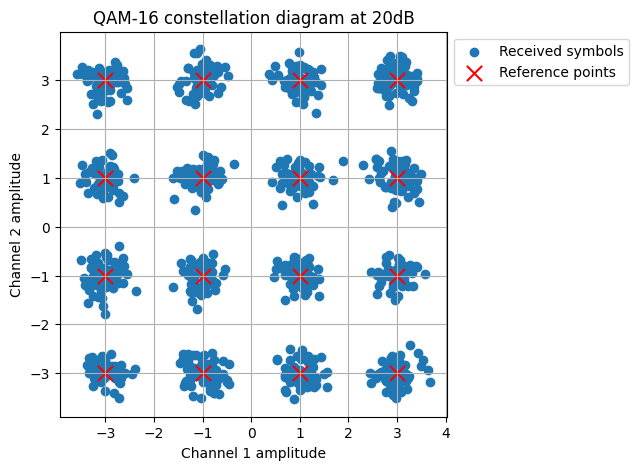

In [10]:
# Apply white noise to our signal so that the SNR is 20dB
qam_scheme = [-3-3j, -3-1j, -3+3j, -3+1j,  \
              -1-3j, -1-1j, -1+3j, -1+1j,  \
               3-3j,  3-1j,  3+3j,  3+1j,  \
               1-3j,  1-1j,  1+3j,  1+1j]
ints = np.random.randint(0,16,1024)
qam_symbols = [qam_scheme[i] for i in ints]
qam_symbols_20db = awgn(qam_symbols, 20)

plt.figure(figsize=(5,5))
plt.scatter(qam_symbols_20db.real, qam_symbols_20db.imag)
plt.scatter(np.real(qam_scheme), np.imag(qam_scheme), s=120, c='red', marker='x')
plt.grid()
plt.title('QAM-16 constellation diagram at 20dB')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.legend(('Received symbols', 'Reference points'), \
           bbox_to_anchor=(1, 1), loc='upper left')

What would happen if we reduced the SNR down to 10dB?

In [11]:
qam_symbols_10db = awgn(qam_symbols,10)

After plotting, note how difficult it is to tell the clusters apart, even though it's the same noise ratio as we experienced with QPSK. In practical communication systems, the modulation scheme is usually adaptable based on the SNR being observed - if we are experiencing poor SNR we might switch from 16-QAM to QPSK, whereas at really high SNR values we could go as high as 4096-QAM!

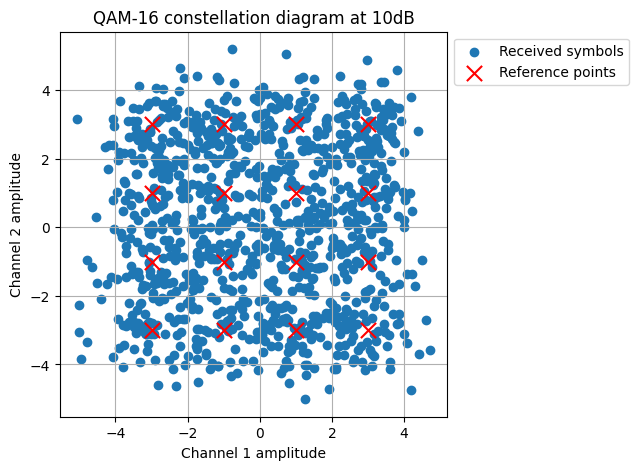

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(qam_symbols_10db.real, qam_symbols_10db.imag)
plt.scatter(np.real(qam_scheme), np.imag(qam_scheme), s=120, c='red', marker='x')
plt.grid()
plt.title('QAM-16 constellation diagram at 10dB')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.legend(('Received symbols', 'Reference points'), \
           bbox_to_anchor=(1, 1), loc='upper left')

We can decide pretty well by just looking at these diagrams whether the quality of our received constellations are good or not. But we can also look at defined metrics engineers use to evaluate the quality of these received signals. One of the key metrics is the EVM, which we will cover next.

## 3. Error Vector Magnitude <a class="anchor" id="evm"></a>

One way of evaluating the quality of the received signals is by calculating the EVM, which is defined as the magnitude of the vector between the received and reference samples points, as a ratio with respect to the magnitude of the reference sample point. Typically it is measured by taking the average over a large number of samples to get a meaningful value.

The EVM is mathematically defined as

$$
\text{EVM} = \frac{\sqrt{\frac{1}{N} \sum^{N}_{n=1}(I_{rx}(n)-I_{0}(n))^2 + (Q_{rx}(n) - Q_{0}(n))^2}}{\sqrt{I_{0}^2 + Q_{0}^2}}
$$

Now that we have a noisy QAM signal, we can calculate the EVM value with respect to the generated clean QAM symbols. Once again in Python we can take advantage of vectorization and using *np.abs* instead of squaring and square rooting. EVM is commonly expressed as a percentage so we will be returning a value of our ratio multiplied by 100.

In [13]:
def calculate_evm(symbols_tx, symbols_rx):
    evm_rms = np.sqrt(np.mean(np.abs(symbols_rx - symbols_tx )**2)) / \
              np.sqrt(np.mean(np.abs(symbols_tx)**2))

    return evm_rms*100

In [14]:
print("QAM-16 EVM at 20dB: {:.2f}%".format(calculate_evm(qam_symbols_20db, qam_symbols)))

QAM-16 EVM at 20dB: 9.96%


Our EVM at 20dB SNR for 16-QAM is only 10%, not bad! What if we used our example data with 10dB SNR?

In [15]:
print("QAM-16 EVM at 10dB: {:.2f}%".format(calculate_evm(qam_symbols_10db, qam_symbols)))

QAM-16 EVM at 10dB: 31.22%


As you can see the error magnitude is now around 30%! If we added even more noise this would be problematic and based on this measure, we might decide to use a less complex modulation scheme, such as QPSK.

## 4. Bit Error Rate <a class="anchor" id="ber"></a>

The Bit Error Rate (BER) is simply defined as the ratio between the number of errors in received bits, $N_e$, and the total number of bits transmitted $N$.

$$
\text{BER} = \frac{N_e}{N}
$$

Let's define a BPSK demodulation function so we can more easily recover bits in a 'for' loop that we will construct to calculate SNR over a range of $E_{b}/N_{o}$ values. In the case of BPSK, we simply check whether our constellation point ended up on the left or right of the Y axis, then the circuit can simply output a 1 or a 0.

In [16]:
def bpsk_demodulate(symbols):
    demodded = [None]*len(symbols)

    for i, symbol in enumerate(symbols):
        if symbol.real >= 0:
            demodded[i] = 1
        else:
            demodded[i] = 0

    return np.array(demodded)

Usually we measure BER over a range of normalized SNR values, denoted as $E_b/N_o$, standing for energy efficiency per bit (Eb) over the noise spectral density or noise per 1Hz of bandwidth. Usually, we will specify a range of $E_b/N_o$ values and calculate the corresponding SNR value based on the (in this case) modulation order.

We use $\text{SNR} = E_b/N_o + 10log10(k) - 10log10(n)$, where $n$ is samples per symbol, and $k$ is number of bits per symbol. Since we are not performing any pulse shaping here, the sampling rate is equivalent to the symbol rate and our value of $n$ will be 1. For a binary modulation scheme like BPSK, $k$ is also 1, and therefore the second and third terms cancel, and SNR is equal to $E_b/N_0$. For more in-depth information refer to Bernard Sklar’s book “Digital Communications: Fundamentals and Applications” [1].

BER graphs are plotted on a logarithmic scale. We will run this loop for a large number of iterations for each $E_b/N_o$ value to produce a nice smooth graph. **The following code cell may take a minute to complete.**

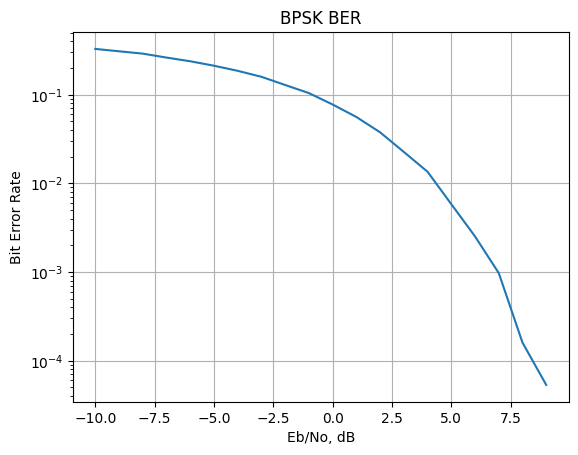

In [17]:
bits = np.random.randint(0,2,16)
bpsk_scheme = [-1+0j, 1+0j]
bpsk_symbols = [bpsk_scheme[i] for i in bits]

ebno_range = np.arange(-10,10)
ber_bpsk = []

for ebno in ebno_range:
    # Generate random bits
    bits_tx = np.random.randint(0,2,75000)

    # Map our bits to BPSK symbols
    bpsk_symbols = [bpsk_scheme[i] for i in bits_tx]

    # Pass symbols through awgn channel
    bpsk_symbols_tx = awgn(bpsk_symbols, ebno)

    # Recover bits from noisy constellations
    bits_rx = bpsk_demodulate(bpsk_symbols_tx)

    # Calculate BER and append to list
    ber_bpsk.append((len(bits_tx)-sum(bits_rx==bits_tx))/len(bits_tx))

plt.semilogy(ebno_range,ber_bpsk)
plt.xlabel('Eb/No, dB')
plt.ylabel('Bit Error Rate')
plt.title('BPSK BER')
plt.grid()

QPSK and higher order QAM signals will be slightly more complex than our BPSK example. Defining our QPSK demodulator function below, we already see the number of outcomes double.

In [18]:
def qpsk_demodulate(symbols):
    demodded_symbols = [None]*len(symbols)

    for i,symbol in enumerate(symbols):
        if symbol.real >= 0:
            if symbol.imag >= 0:               # upper right quadrant ++
                demodded_symbols[i] = 0
            else:                              # lower right quadrant +-
                demodded_symbols[i] = 1
        else:
            if symbol.imag >= 0:               # upper left quadrant -+
                demodded_symbols[i] = 2
            else:                              # lower left quadrant --
                demodded_symbols[i] = 3

    return np.array(demodded_symbols)

Also, since the QPSK modulation scheme uses 2 bits to represent 1 symbol, we employ an additional lookup dictionary so we can convert our recovered QPSK symbols into bits.

In [19]:
# We'll use this dictionary to map our integers into bits for QPSK BER
binary_mapping = {0 : (0, 0),
                  1 : (0, 1),
                  2 : (1, 0),
                  3 : (1, 1)}

Just like the BPSK plot, we will run this for many thousands of iterations. Do note that now we have 2 output lists defined - *ser_qpsk* and *ber_qpsk*. SER in this case stands for Symbol Error Rate and while BER == SER for the BPSK case, the SER will differ for QPSK and higher order QAM modulations since they use more than 1 bit to represent a symbol. **The following code cell may take a minute to complete.**

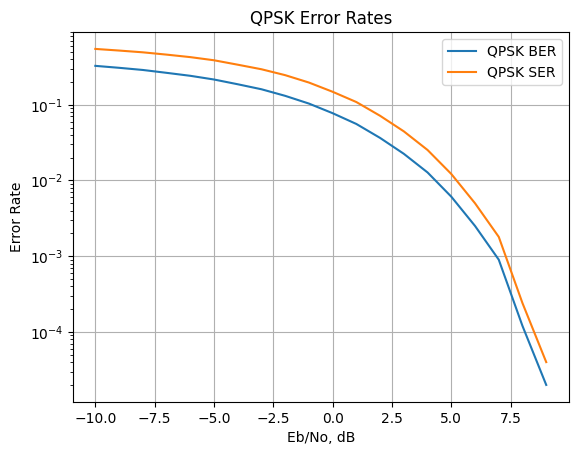

In [20]:
ebno_range = np.arange(-10,10)
ser_qpsk, ber_qpsk = [], []

for ebno in ebno_range:
    # Generate random integers
    ints_tx = np.random.randint(0,4,50000)

    # Map them to symbols given our QPSK scheme
    qpsk_symbols = [qpsk_scheme[i] for i in ints_tx]

    # Add noise for each Eb/No value
    snr = ebno + 10*np.log10(2)
    qpsk_symbols_tx = awgn(qpsk_symbols,snr)

    # Recover symbols from the noisy constellations
    ints_rx = qpsk_demodulate(qpsk_symbols_tx)

    # Calculate SER and append to list
    ser_qpsk.append((len(ints_tx)-sum(ints_rx==ints_tx))/len(ints_tx))

    # convert to bits
    bits_tx = np.array([binary_mapping[symbol] for symbol in ints_tx]).reshape(-1)
    bits_rx = np.array([binary_mapping[symbol] for symbol in ints_rx]).reshape(-1)

    # Calculate BER and append to list
    ber_qpsk.append(np.sum(bits_tx != bits_rx)/len(bits_tx))

plt.semilogy(ebno_range,ber_qpsk)
plt.semilogy(ebno_range,ser_qpsk)
plt.title('QPSK Error Rates')
plt.xlabel('Eb/No, dB')
plt.ylabel('Error Rate')
plt.legend(('QPSK BER', 'QPSK SER'))
plt.grid()

As we can see with the case of QPSK, all higher order modulation schemes will have a higher SER. But a high SER doesn't mean that we will not get **some** of the bits correct i.e. if we receive a QPSK symbol carrying bits '10', while a '11' was sent. While the symbol is incorrect, we still received half of the bits correctly.

## 5. Conclusion
We briefly investigated SNR and link quality evaluation metrics including the EVM and BER. In the next notebook we will look at why we want to modify symbol pulses before transmission, using pulse shaping filters.

---

[⬅️ Previous Notebook](01_baseband_modulation.ipynb) || [Next Notebook 🚀](03_pulse_shaping.ipynb)

Copyright © 2023 Strathclyde Academic Media

---
---